## What are we learning?

- What is causal machine learning?
- How does it improve over traditional causal inference?
- What are its limitations?

## Introduction

- In the potential outcomes framework, we are usually interested in the quantity of the average treatment effect (ATE) or the average treatment on the treated (ATT)
- What are these?

## Potential Outcomes

- For simplicity, we will assume a binary variable that takes on a value of 1 if a particular unit receives the treatment and a 0 if it does not.
- Each unit will have two potential outcomes, but only one observed outcome. 
Potential outcomes are defined as $Y_i^1$ if unit received the treatment and $Y_i^0$ if the unit did not. 
    - Notice that both potential outcomes have the same 
 subscript
    - Two separate states of the world for the exact same person in our example at the exact same moment in time. 
    - The state of the world where no treatment occurred is the *control state*. 
Each unit has two potential outcomes: a potential outcome under a state of the world where the treatment occurred ($Y^1$) and a potential outcome where the treatment did not occur ($Y^0$).
- An observed outcome is just $Y_i$; they are the actual, realized data.

## The Switching Equation

- The switching equation is a way to think about the difference between the potential outcomes and the observed outcomes.
- The switching equation is defined as:

$$
Y_i = D_iY_i^1 + (1-D_i)Y_i^0
$$

where $D_i$ is a binary variable that takes on a value of 1 if the unit received the treatment and 0 if it did not.



## The Fundamental Problem of Causal Inference

- The fundamental problem of causal inference is that we can only observe one of the potential outcomes for each unit.
- This is known as the **fundamental problem of causal inference**.
- What we want *ideally*, is the treatment effect of each unit, which is defined:

$$
\delta_i = Y_i^1 - Y_i^0
$$

But we only ever know one of these


## Average Treatment Effect

From this definition, we get three interesting quantities:

- The average treatment effect (ATE) is defined as:

$$
\delta = E[Y^1 - Y^0] = E[Y^1] - E[Y^0]
$$

- The average treatment effect on the treated (ATT) is defined as:

$$
\delta_{ATT} = E[Y^1 - Y^0 | D = 1] 
$$

$$
= E[Y^1 | D = 1] - E[Y^0 | D = 1]
$$

- The average treatment effect on the untreated (ATU) is defined as:

$$
\delta_{ATU} = E[Y^1 - Y^0 | D = 0]
$$

$$
= E[Y^1 | D = 0] - E[Y^0 | D = 0]
$$

All three of these quantities are population means and are fundamentally unobservable.

## The ATT

- The ATT is the average treatment effect for those who actually received the treatment.
- The ATT is almost always different from the ATE because people will sort into a treatment based on whether it will help them.
- Notice that we need two observations for each unit to calculate the ATT.


## The ATU

- Similar to the ATT, the ATU is the average treatment effect for those who did not receive the treatment.
- We also need two observations on each unit to calculate the ATU.
- $ATT \neq ATU$ in general, because there is *heterogeneity* in treatment effects
    - The treatment effect is different for different people

## $\delta_i$ Again

- Look back to the previous slides
- We sort of jumped from $\delta_i$ to $\delta$.
- It is true that the average treatment effects are useful policy variables
- But what if we were also interested in understanding the distribution of the treatment effect?
- What if we also wanted to understand how covariates interact with treatment effect?
- What if we had enough data to actually estimate that quantity?

## Causal Machine Learning

- Causal machine learning brings the power of machine learning into the space of causal inference by using its tools to estimate richer estimands

## Traditional Machine Learning vs. Causal Inference

- In machine learning, we want to find the model that best *predicts* the outcome.
- In causal inference, we need to understand the underlying mechanisms and effects of given variables **on** the outcome

<div>
<img src="assets/supervised_ml_schematic.png" width="500"/>
<img src="assets/causalinference_schematic.png" width="500"/>
</div>

## How can ML help?

- But if that's the case, how can machine learning even be incorporated into causal inference?
    - Allows more flexibility in modeling nonlinear relationships
    - So better than linear regression
- Among a large set of covariates, it can help us choose which covariates are most important, rather than relying solely on expert opinion
- It can also let us discover the *conditional average treatment effect* (CATE)

$$
CATE = E(Y^1 - Y^0 | X)
$$

## Covariate Selection with LASSO

- Same LASSO that we learned about in previous lectures
- LASSO solves the following problem:

$$
\hat{\beta}_{lasso} = \underset{\beta}{\text{argmin}} \left( \sum_{i=1}^{n} (y_i - x_i^T \beta)^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right)
$$

## Why use LASSO?

- Confounder Discovery: In causal inference, we often have hundreds of potential confounders (demographics, history, text data). We don't know which ones are "true" confounders.
- Sparsity: We assume that the underlying truth is "sparse"—only a small subset of these variables actually affects the outcome.
- Objective: We want to use LASSO to sift through the noise and find the relevant control variables to satisfy the "Backdoor Criterion."

**Looking Ahead**

- We know that OLS is BLUE (Best Linear Unbiased Estimator)
- Is LASSO, OLS?
- So does that mean it's BLUE?
    - Which part is it in danger of losing?
    - Is it Best?
    - Is it Linear?
    - Is it Unbiased?
    - Is is it an Estimator?


## Okay, let's use it!

- What would happen if we just used LASSO and went ahead with it?
- Let's say we have $Y$, $T$, $X_1,...,X_p$

1. Run LASSO of $Y$ on $T,X$
2. Keep all variables with non-zero coefficients, $X_i$
3. Re-run OLS of $Y$ on $T,X_i$ to get p-values.

- Let's assume a sample size of $N=100$ and that we have $p=200$ covariates
- What would happen if we threw all 200 covariates in?

In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, LassoLarsIC, Lasso
import statsmodels.api as sm
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from doubleml import DoubleMLData, DoubleMLPLR
from econml.dml import CausalForestDML
import lingam
import networkx as nx
from pgmpy.estimators import PC
from pgmpy.base import DAG

In [2]:

# 1. Generate Synthetic Data
np.random.seed(10)

coef_single_list = []
single_confounder_drop_list = []

for i in range(1000):
    n = 30  # number of observations
    p = 90  # potential control variables

    # Generate random controls (X)
    X = np.random.normal(0, 1, size=(n, p))
    confounder_indices = np.arange(5)  # First 7 variables are true confounders
    X = pd.DataFrame(X, columns=[f"X{i}" if i not in confounder_indices else f"X_hidden_{i}" for i in range(p)])

    # Define the confounders
    # They strongly affect Treatment (D), but weakly affect Outcome (Y)
    hidden_confounder = X.filter(like='X_hidden_').values
    num_confounders = hidden_confounder.shape[1]

    # Generate Treatment (D)
    # D is strongly determined by the hidden confounders
    D = np.repeat(1, num_confounders)[np.newaxis, :] @ hidden_confounder.T + np.random.normal(0, 1, size=n)

    # Generate Outcome (Y)
    # The hidden confounder has a small direct effect 
    true_effect = 5.0
    Y = 1 + true_effect * D + np.repeat(.01, num_confounders)[np.newaxis, :] @ hidden_confounder.T + np.random.normal(0, 1 , size=n)

    # --- STEP 1: The Naive LASSO Selection ---

    # We use LASSO to select variables that predict Y
    lasso = LassoCV(cv=5).fit(X, Y.flatten())

    # Get the indices of variables LASSO decided to keep
    selected_indices = np.where(lasso.coef_ != 0)[0]
    # print(f"LASSO selected {len(selected_indices)} variables out of {p}.")

    # Check how many of our 5 confounders were kept
    kept_confounders = set(selected_indices).intersection(set(confounder_indices))
    # print(f"Real Confounders kept: {len(kept_confounders)} out of {len(confounder_indices)}")

    # --- STEP 2: The Final Regression ---

    # We build the final dataset using only what LASSO selected
    X_selected = X.iloc[:, selected_indices]

    # Run OLS: Y ~ D + Selected_X
    X_final = sm.add_constant(
        pd.concat([pd.Series(D.flatten(), name="D"), X_selected], axis=1)
        )

    model = sm.OLS(Y.flatten(), X_final).fit()

    # print("\n" + "="*40)
    # print(f"True Causal Effect: {true_effect}")
    # print(f"Estimated Effect:   {model.params[1]:.4f}")
    # print("="*40)
    # print(model.summary())
    
    coef_single_list.append(model.params[1])
    single_confounder_drop_list.append(len(kept_confounders))



## What happened here?

- In this example, the variables were weakly correlated to the outcome, but strongly correlated to treatment.
- **Omitted Variable Bias**: LASSO is designed for prediction, not parameter estimation. It might drop a variable that is weakly correlated with $Y$ but strongly correlated with $D$. 
    - Dropping this variable causes omitted variable bias in your treatment estimate.
- **Invalid Confidence Intervals**: The standard errors in step 3 assume the model was fixed in advance. They do not account for the uncertainty of the selection process itself. 
    - This is similar to needing to adjust standard errors for IV

## Regularization causes **BIAS**

- The "Beta-Min" Condition: For Naive LASSO to work, all confounders must have large coefficients on $Y$.
    - But many confounders affect the treatment ($D$) strongly but the outcome ($Y$) only weakly.
- The Result (Omitted Variable Bias): LASSO drops the "weak" confounder to save variance.
    - But because that confounder strongly drives $D$, dropping it re-opens the backdoor path.
    - Outcome: Your Treatment Effect estimate absorbs the bias. The p-values are wrong, and the confidence intervals do not contain the true effect.

**Key Takeaway: Good prediction of the outcome does not guarantee a good estimate of the causal effect.**

## Solution 1: Post-Double Selection

- Choose variables that are the union of those important for the outcome and for the treatment

- Step 1 (Outcome Selection): Run LASSO of $Y \sim X$. Keep selected variables ($S_1$).
- Step 2 (Treatment Selection): Run LASSO of $D \sim X$. Keep selected variables ($S_2$).
- Step 3 (Union): Take the union of variables $S_{Union} = S_1 \cup S_2$.
- Step 4 (Refitting): Run OLS of $Y$ on $D$ and $S_{Union}$.
---
- It catches weak predictors of $Y$, that are strong predictors of $D$.
- It removes the regularization bias from the final estimate

In [3]:
coef_double_list = []
double_confounder_drop_list = []

for i in range(1000):

    n = 30  # number of observations
    p = 90  # potential control variables

    # Generate random controls (X)
    X = np.random.normal(0, 1, size=(n, p))
    confounder_indices = np.arange(5)  # First 7 variables are true confounders
    X = pd.DataFrame(X, columns=[f"X{i}" if i not in confounder_indices else f"X_hidden_{i}" for i in range(p)])

    # Define the confounders
    # They strongly affect Treatment (D), but weakly affect Outcome (Y)
    hidden_confounder = X.filter(like='X_hidden_').values
    num_confounders = hidden_confounder.shape[1]

    # Generate Treatment (D)
    # D is strongly determined by the hidden confounders
    D = np.repeat(1, num_confounders)[np.newaxis, :] @ hidden_confounder.T + np.random.normal(0, 1, size=n)

    # Generate Outcome (Y)
    # The hidden confounder has a small direct effect 
    true_effect = 5.0
    Y = 1 + true_effect * D + np.repeat(.01, num_confounders)[np.newaxis, :] @ hidden_confounder.T + np.random.normal(0, 1 , size=n)


    # ---  Outcome Selection ----
    # We use LASSO to select variables that predict Y
    lasso_y = LassoCV(cv=5).fit(X, Y.flatten())

    # ---- Treatment Selection ----
    lasso_d = LassoCV(cv=5).fit(X, D.flatten())

    # ---- Select Variables in the Union ----

    # Get the indices of variables LASSO decided to keep
    selected_indices_y = np.where(lasso_y.coef_ != 0)[0]
    # print(f"LASSO (y) selected {len(selected_indices_y)} variables out of {p}.")

    # Check how many of our 5 confounders were kept
    kept_confounders_y = set(selected_indices_y).intersection(set(confounder_indices))
    # print(f"Real Confounders kept: {len(kept_confounders_y)} out of {len(confounder_indices)}")

    selected_indices_d = np.where(lasso_d.coef_ != 0)[0]
    # print(f"LASSO (d) selected {len(selected_indices_d)} variables out of {p}.")

    union_indices = np.union1d(selected_indices_y, selected_indices_d)
    # print(f"Union selected {len(union_indices)} variables out of {p}.")
    
    kept_confounders = set(union_indices).intersection(set(confounder_indices))

    # --- The Final Regression ---

    # We build the final dataset using only what LASSO selected
    X_selected = X.iloc[:, union_indices]

    # Run OLS: Y ~ D + Selected_X
    X_final = sm.add_constant(
        pd.concat([pd.Series(D.flatten(), name="D"), X_selected], axis=1)
        )

    model = sm.OLS(Y.flatten(), X_final).fit()

    # print("\n" + "="*40)
    # print(f"True Causal Effect: {true_effect}")
    # print(f"Estimated Effect:   {model.params[1]:.4f}")
    # print("="*40)
    # print(model.summary())
    
    coef_double_list.append(model.params[1])
    double_confounder_drop_list.append(len(kept_confounders))

## Solution 2: Double Machine Learning

- More general and robust than post-double selection
- Isn't just valid for LASSO

- Step 1: Predict Y: Use ML to predict $\hat{Y}$ from $X$. 
- Step 2: Calculate Residuals: $\tilde{Y} = Y - \hat{Y}$.
- Step 3: Predict D: Use ML to predict $\hat{D}$ from $X$. 
- Step 4: Calculate Residuals: $\tilde{D} = D - \hat{D}$.

Note: This step removes the influence of confounders from the treatment.

- Step 5: Regress Residuals: Run OLS: $\tilde{Y} = \tau \tilde{D} + \epsilon$.

In [4]:
# Let's use an SVM for this

coef_doubleml_list = []

for i in range(1000):   

    n = 30  # number of observations
    p = 90  # potential control variables

    # Generate random controls (X)
    X = np.random.normal(0, 1, size=(n, p))
    confounder_indices = np.arange(5)  # First 7 variables are true confounders
    X = pd.DataFrame(X, columns=[f"X{i}" if i not in confounder_indices else f"X_hidden_{i}" for i in range(p)])

    # Define the confounders
    # They strongly affect Treatment (D), but weakly affect Outcome (Y)
    hidden_confounder = X.filter(like='X_hidden_').values
    num_confounders = hidden_confounder.shape[1]

    # Generate Treatment (D)
    # D is strongly determined by the hidden confounders
    D = np.repeat(1, num_confounders)[np.newaxis, :] @ hidden_confounder.T + np.random.normal(0, 1, size=n)

    # Generate Outcome (Y)
    # The hidden confounder has a small direct effect 
    true_effect = 5.0
    Y = 1 + true_effect * D + np.repeat(.01, num_confounders)[np.newaxis, :] @ hidden_confounder.T + np.random.normal(0, 1 , size=n)

    # ---  Outcome Selection ----
    # predict y with SVR
    model_y = SVR(kernel='linear').fit(X, Y.flatten())
    coef_y = model_y.coef_.flatten()
    
    y_pred = model_y.predict(X)
    residuals_y = Y.flatten() - y_pred

    # ---- Treatment Selection ----
    model_d = SVR(kernel='linear').fit(X, D.flatten())
    coef_d = model_d.coef_.flatten()
    
    d_pred = model_d.predict(X)
    residuals_d = D.flatten() - d_pred

    # --- The Final Regression ---

    # Run OLS: Y_hat ~ D_hat
    X_final = pd.concat([pd.Series(D.flatten(), name="D"), X_selected], axis=1)

    model = sm.OLS(y_pred, d_pred).fit()
    
    coef_doubleml_list.append(model.params[0])


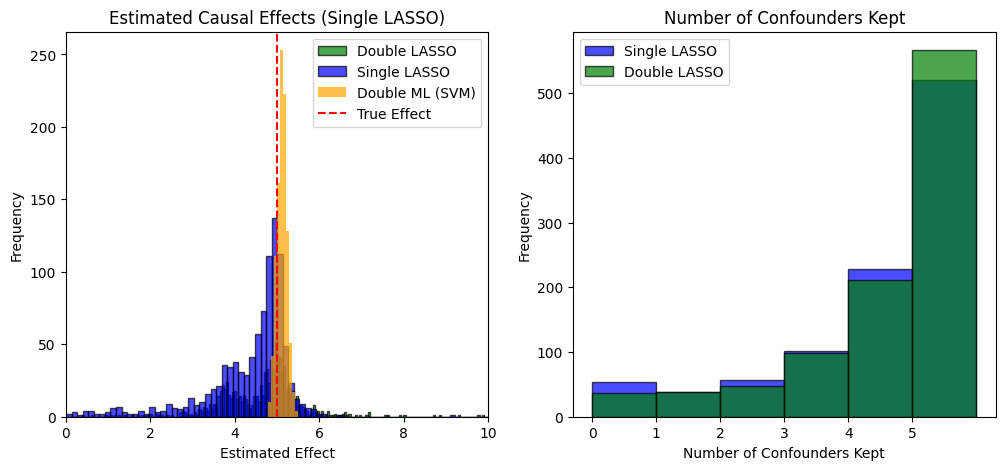

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(coef_double_list, bins=1000, alpha=.7, color='green', edgecolor='black', label='Double LASSO');
ax[0].hist(coef_single_list, bins=1000,alpha=.7, color='blue', edgecolor='black', label='Single LASSO')
ax[0].hist(coef_doubleml_list, bins=10, alpha=.7, color='orange',  label='Double ML (SVM)');

ax[0].axvline(x=5.0, color='red', linestyle='--', label='True Effect')
ax[0].set_title('Estimated Causal Effects (Single LASSO)')
ax[0].set_xlabel('Estimated Effect')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[0].set_xlim(0, 10)


ax[1].hist(single_confounder_drop_list, bins=range(0,7), alpha=.7, color='blue', edgecolor='black', label='Single LASSO');
ax[1].set_title('Number of Confounders Kept')
ax[1].set_xlabel('Number of Confounders Kept')
ax[1].set_ylabel('Frequency')
ax[1].set_xticks(range(0,6))

ax[1].hist(double_confounder_drop_list, bins=range(0,7), alpha=.7, color='green', edgecolor='black', label='Double LASSO');
ax[1].set_title('Number of Confounders Kept')
ax[1].set_xlabel('Number of Confounders Kept')
ax[1].set_ylabel('Frequency')
ax[1].set_xticks(range(0,6))
ax[1].legend()



## Post Double Lasso vs. Post Single Lasso vs. DoubleML

| Feature         | Naive Selection         | Double Selection        | Double ML (DML)     |
| :-------------- | :---------------------- | :---------------------- | :------------------ |
| Model           | LASSO Only              | Linear LASSO            | Any ML (Trees, Nets)      |
| Bias            | High (Omitted Variable) | Low                     | Low                 |
| Selection Logic | Predict Y only          | Predict Y AND D         | Residualize Y AND D |
| Inference       | Invalid p-values        | Valid                   | Valid               |
| Use Case        | Never                   | Linear assumptions hold | Complex/Non-linear  |

- The basic difference between Double Selection and DoubleML is principally the algorithm used. 
- With the power of more complex models, it's possible to get even more precise results.

## The Post-Selection Problem with Confidence Intervals

**The Scenario:**

You ran LASSO, selected 5 variables out of 200, and put them into OLS. You now check the p-value or Confidence Interval (CI).

**The Problem:**

Standard OLS software assumes the model was *fixed in advance (by theory)*.

- It calculates variance assuming the selected variables are the only possible variables.
- It ignores the uncertainty of the selection process itself.

**The Consequence**:

- Your standard errors are systematically too small.

- Your Confidence Intervals are too narrow.

Result: High Type I Error (False Positives). You find "significance" where there is only noise.

## Single Post Selection CIs

Decomposition of Uncertainty:

The total uncertainty of your estimate $\hat{\tau}$ is a sum of two components:
- Estimation Uncertainty: Noise in the data given the model.
- Selection Uncertainty: The probability that LASSO picked the "wrong" control variables.

Naive OLS Formulation:

$$
\text{Var}_{total} \approx \text{Var}_{estimation} + \underbrace{\text{Var}_{selection}}_{ignored!}
$$

Because LASSO is data-driven, slight changes in the data lead to different variables being selected. Naive OLS ignores this volatility, acting as if the selected model is the absolute "Truth."

## Fixing the Issue

- For single-post-selection we need to account for the fact that the LASSO may make a mistake and drop a variable that is actually important.
- With Double Selection, it is sufficient to use the p-values and CIs from the post-OLS regression
- For DoubleML, however, it is necessary to calculate standard errors, CIs and p-values. 
- We can do this by Cross-Fitting

## Cross-Fitting

- Split Data: Divide sample into $K$ folds (e.g., Fold A and Fold B).
- Train (Fold A): Train LASSO on Fold A to learn the relationships ($Y \sim X$ and $D \sim X$).
- Predict (Fold B): Use those models to calculate residuals ($\tilde{Y}, \tilde{D}$) on Fold B.
    - Note: The models used to create residuals for Fold B never saw Fold B's data.
- Swap: Train on B, residualize A.
- Estimate: Run OLS on the stacked residuals from the whole dataset.

**Why this fixes the Confidence Interval:**

- This removes Overfitting Bias. 
- The estimator $\hat{\tau}$ converges to a Normal Distribution, making standard p-values valid again.

## Using the `DoubleML` Library



In [6]:
n = 30  # number of observations
p = 90  # potential control variables

# Generate random controls (X)
X = np.random.normal(0, 1, size=(n, p))
confounder_indices = np.arange(5)  # First 7 variables are true confounders
X = pd.DataFrame(X, columns=[f"X{i}" if i not in confounder_indices else f"X_hidden_{i}" for i in range(p)])

# Define the confounders
# They strongly affect Treatment (D), but weakly affect Outcome (Y)
hidden_confounder = X.filter(like='X_hidden_').values
num_confounders = hidden_confounder.shape[1]

# Generate Treatment (D)
# D is strongly determined by the hidden confounders
D = np.repeat(1, num_confounders)[np.newaxis, :] @ hidden_confounder.T + np.random.normal(0, 1, size=n)

# Generate Outcome (Y)
# The hidden confounder has a small direct effect 
true_effect = 5.0
Y = 1 + true_effect * D + np.repeat(.01, num_confounders)[np.newaxis, :] @ hidden_confounder.T + np.random.normal(0, 1 , size=n)

# 2. DEFINE THE MACHINE LEARNERS
# We use LassoCV for both models (Outcome and Treatment)
learner_y = SVR(kernel='linear')
learner_d = SVR(kernel='linear')

df = pd.concat([pd.Series(Y.flatten(), name='y'), 
           pd.Series(D.flatten(), name='d'), 
           X], axis=1)


# 3. INITIALIZE DOUBLE ML DATA
# We tell it which column is the outcome ('y'), treatment ('d'), and controls (X)
obj_dml_data = DoubleMLData(df, y_col = 'y', d_cols = 'd', x_cols=None, )

# 4. INITIALIZE THE MODEL (PLR = Partially Linear Regression)
# n_folds=5: This enables Cross-Fitting (Split data into 5 parts)
dml_plr = DoubleMLPLR(obj_dml_data,
                      ml_l = learner_y,  # Learner for E[Y|X]
                      ml_m = learner_d,  # Learner for E[D|X]
                      n_folds = 5)

# 5. FIT THE MODEL
print("Fitting DoubleML with Cross-Fitting...")
dml_plr.fit()

# 6. RESULTS
print("\n" + "="*40)
print(dml_plr.summary)
print("="*40)

Fitting DoubleML with Cross-Fitting...

       coef   std err          t  P>|t|     2.5 %    97.5 %
d  5.181785  0.121457  42.663544    0.0  4.943734  5.419837


## Causal Forests and Heterogeneous Treatment Effects

- Methods like DML and Double LASSO are excellent for finding the Average Treatment Effect (ATE).
- The limitation: ATE assumes the treatment works roughly the same for everyone.
    - i.e. homogeneous treatment
- Reality: The treatment might work well for Group A, have no effect on Group B, and harm Group C.

We want to estimate the CATE:

$$
\tau(x) = E[Y | D=1, X=x] - E[Y | D=0, X=x]
$$

- So in so far as we can think of an individual as a unit with certain characteristics, this gives us a individual treatment effect
- This is great for understanding the varying impacts of treatments and can answer the question:
    - Who do we treat?

## Causal Forests vs. Prediction Forests

- Standard Random Forests are designed to minimize prediction error on $Y$. 
- Causal Forests are designed to minimize error on $\tau(x)$.

| Feature        | Standard Random Forest             | Causal Forest                                                  |
| :------------- | :--------------------------------- | :------------------------------------------------------------- |
| Objective      | Minimize MSE of Outcome (Y)        | Maximize variance of Effect (τ)                                |
| Ground Truth   | We observe Y (easy to validate)    | We never observe τi​ (fundamental problem of causal inference) |


**The Challenge**: Since we can't see the "true" treatment effect for an individual, we cannot simply train a forest to predict it. We need a proxy objective function.

## The Solution

**Innovation 1: The Splitting Rule**

- Standard trees split to reduce variance in the outcome.
- Causal trees split to maximize the difference in treatment effects between the two child nodes.
- Intuition: We want to find a cut (e.g., Age > 50) where the treatment effect on the left is very different from the treatment effect on the right.

**Innovation 2: "Honesty" (Sample Splitting)**

- In standard RF, we use the same data to decide the splits and to calculate the leaf values. This causes bias (overfitting).
- In Causal Forests, we split the data into two halves:
    - Split-sample ($J_1$): Used only to build the tree structure (decide the cuts).
    - Estimate-sample ($J_2$): Used only to estimate the treatment effect within the chosen leaves.
- This decoupling makes the standard errors valid.

## Big Innovation: Local Centering (Orthogonalization)

**Connecting to Double Machine Learning (DML):**

- Causal Forests effectively combine DML with Random Forests. 
- Before building the trees, they perform "Local Centering":
    - Residualize Y: Remove the effect of controls on Outcome ($Y - \hat{E}[Y|X]$).
    - Residualize D: Remove the effect of controls on Treatment ($D - \hat{E}[D|X]$).
- The Result: The Causal Forest runs on these residuals. It looks for subpopulations ($X$) where the relationship between the residual outcome and residual treatment changes.

| Method              | Best Use Case                                                | Weakness for Heterogeneity                                         |
| :------------------ | :----------------------------------------------------------- | :----------------------------------------------------------------- |
| LASSO (Interaction) | Identifying a few key drivers of heterogeneity.              | "Assumes linear interactions (e.g., D×Age). Fails if relationship is non-linear."
| Double ML (DML)     | Estimating the Global Average Effect (ATE).                  | "Usually outputs a single number. To get CATE, you must pre-specify the model (e.g., Linear DML)."
| Causal Forests      | Discovery. Finding unknown subgroups with different effects. | Requires more data (N > 500-1000). computationally more expensive. |

**Key Advantage:** Causal Forests are non-parametric. You don't need to know which variables modify the treatment effect; the forest discovers the interactions automatically.

## When to use Causal Forests

- Scenario A: Targeting / Personalization
    - "We want to give coupons only to users who will actually spend more because of them.
    - "Causal Forest estimates $\tau(x)$ for every user. You treat only if $\tau(x) > \text{Cost}$.
- Scenario B: Subgroup Analysis"
    - Did the drug work better for older patients with low income?"
    - Instead of running 50 different regressions, run one Causal Forest and plot the Partial Dependence of $\tau(x)$ on Age and Income.
- Scenario C: Data-Driven Hypothesis Generation
    - You don't have a theory about who responds best. You want the data to tell you.

Average Treatment Effect (True): 0.92
Training Causal Forest (this may take a moment)...
Inference complete.


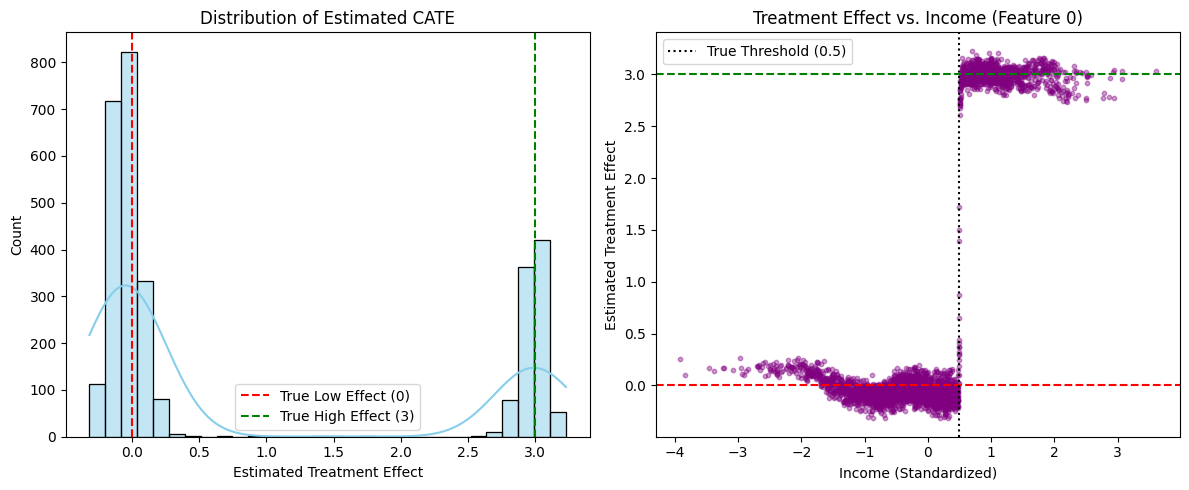

In [7]:
# --- STEP 1: GENERATE HETEROGENEOUS DATA ---
np.random.seed(42)
n_samples = 3000
n_features = 10

# X: Customer features (Age, Income, etc.)
X = np.random.normal(0, 1, size=(n_samples, n_features))
# Let's say column 0 is "Income"
income = X[:, 0]

# T: Treatment (Randomly assigned binary treatment, 50/50 split)
T = np.random.binomial(1, 0.5, size=n_samples)

# THE TRUTH (CATE):
# If Income > 0.5, the treatment effect is +3.0.
# If Income <= 0.5, the treatment effect is 0.0.
true_te = np.where(income > 0.5, 3.0, 0.0)

# Y: Outcome (Sales)
# Base sales depend on other features (confounders/controls), plus the treatment effect
y_base = 2.0 * X[:, 1] + 0.5 * X[:, 2] # Some noise from other features
Y = y_base + (true_te * T) + np.random.normal(0, 1, size=n_samples)

print(f"Average Treatment Effect (True): {np.mean(true_te):.2f}")


# --- STEP 2: TRAIN CAUSAL FOREST ---

# We use CausalForestDML
# model_y: Model to predict Outcome from X (to residualize Y)
# model_t: Model to predict Treatment from X (to residualize T - propensity score)
cf = CausalForestDML(model_y=LassoCV(),
                     model_t=LassoCV(),
                     discrete_treatment=True,
                     n_estimators=100,
                     min_samples_leaf=10,
                     random_state=42)

print("Training Causal Forest (this may take a moment)...")
cf.fit(Y, T, X=X)

# --- STEP 3: INFER HETEROGENEITY ---

# Predict the treatment effect for every single user in the dataset
cate_estimates = cf.effect(X)

print("Inference complete.")


# --- STEP 4: VISUALIZE RESULTS ---

plt.figure(figsize=(12, 5))

# Plot 1: Distribution of Estimated Effects
# We expect two peaks: one around 0.0 and one around 3.0
plt.subplot(1, 2, 1)
sns.histplot(cate_estimates, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='red', linestyle='--', label='True Low Effect (0)')
plt.axvline(3, color='green', linestyle='--', label='True High Effect (3)')
plt.title('Distribution of Estimated CATE')
plt.xlabel('Estimated Treatment Effect')
plt.legend()

# Plot 2: CATE vs. The Driver (Income)
# We plot the estimated effect against Feature 0 (Income).
# We should see a "step function": low effect for X < 0.5, high for X > 0.5.
plt.subplot(1, 2, 2)
plt.scatter(income, cate_estimates, alpha=0.4, s=10, c='purple')
plt.axhline(0, color='red', linestyle='--')
plt.axhline(3, color='green', linestyle='--')
plt.axvline(0.5, color='black', linestyle=':', label='True Threshold (0.5)')
plt.title('Treatment Effect vs. Income (Feature 0)')
plt.xlabel('Income (Standardized)')
plt.ylabel('Estimated Treatment Effect')
plt.legend()

plt.tight_layout()
plt.show()

ExactExplainer explainer: 3001it [14:44,  3.37it/s]                          


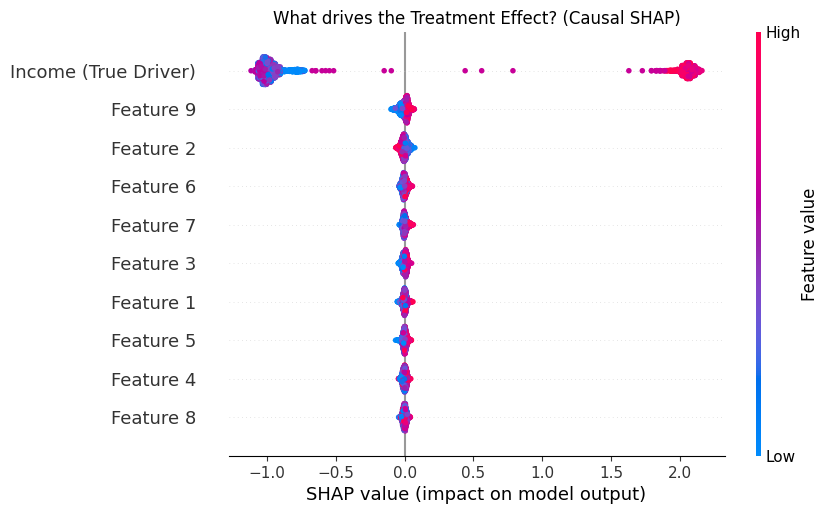

In [8]:
import shap

# --- STEP 1: PREPARE SHAP ---
# "shap_values" calculates the contribution of each feature to the CATE estimate
# We pass the Causal Forest model and the X data
explainer = shap.Explainer(cf.effect, X)
shap_values = explainer(X)

# Assign feature names for clarity
shap_values.feature_names = [f"Feature {i}" for i in range(X.shape[1])]
# Rename Feature 0 to "Income" since we know that's the driver
shap_values.feature_names[0] = "Income (True Driver)"


# --- STEP 2: THE BEESWARM PLOT ---
plt.figure(figsize=(10, 6))
plt.title("What drives the Treatment Effect? (Causal SHAP)")

# The 'beeswarm' plot summary
shap.plots.beeswarm(shap_values, max_display=10, show=True)

## Exploring Feature Importance in the CATE Estimates

- Just as we saw with standard machine learning, we can use shapley values to understand the covariates that drive the heterogeneity.

**The Situation:**

- You ran a Causal Forest.
- You found that the Treatment Effect varies wildly (e.g., from 0 to +3.0).

**The Question:** "What characterizes the people with the +3.0 effect?"

**The Problem:** A Random Forest is a complex ensemble of thousands of trees. You cannot simply look at "coefficients" like in Linear Regression. We need a way to decompose the estimated effect $\hat{\tau}(x)$ back into the contribution of each feature.

## Why Standard Feature Importance Fails

- Standard Permutation Importance: In standard ML, we shuffle a column and see how much the MSE of Y increases.
- In Causal Inference: We don't care about predicting $Y$ (Outcome). We care about predicting $\tau$.
- A variable might be a strong predictor of Sales (e.g., Seasonality) but have zero impact on the Effect of the Coupon. 
- Standard importance metrics often confuse these two.

## Causal Shapley Values

Causal SHAP Values

- The Adaptation: Instead of explaining the prediction of $Y$, we explain the prediction of the CATE model $\hat{\tau}(x)$.
$$
\hat{\tau}(\text{User}_i) = \text{Average Effect} + \sum \text{SHAP}_j
$$

- "This user's treatment effect is +3.0. Why?"

- Because they are High Income (+1.5 contribution)
- Because they are Young (+0.5 contribution)
- Base Average Effect (+1.0)"

## Causal Discovery

- DAGs are powerful ways of understanding and conceptualizing the causal mechanisms that drive a treatment.
-  But they also require a lot of domain knowledge
    - And an assumption that everything not in the DAG, is also not important or a driver of the mechanism.
- But what if we could *discover* the DAG?

## Conditional Independence

Reichenbach's Common Cause Principle:

- If two variables $X$ and $Y$ are statistically dependent, then either $X \to Y$, or $Y \to X$, or there exists a common cause $Z$ such that $X \leftarrow Z \to Y$.

- We can identify structures by looking at when variables become conditionally independent.

- **The Fork**: $X \leftarrow Z \to Y$. $X$ and $Y$ are dependent. But if we control for $Z$, they become independent ($X \perp \!\!\! \perp Y | Z$).
- **The Chain**: $X \to Z \to Y$. $X$ and $Y$ are dependent. If we control for $Z$, they become independent.
- **The Collider**: $X \to Z \leftarrow Y$. $X$ and $Y$ are independent. But if we control for $Z$ (or its descendants), they become dependent.

## Approach 1 — Constraint-Based (e.g., PC Algorithm)

- How it works: Start fully connected: Assume every variable causes every other variable.
- Test Independence: For every pair $(X, Y)$, test if they are independent. If yes, delete the edge.
- Test Conditional Independence: For remaining pairs, test if they become independent when conditioning on a third variable $Z$. If yes, delete the edge.
- Orient Edges: Look for "V-structures" ($X-Z-Y$ where $X$ and $Y$ are independent, but dependent given $Z$). Orient them $X \to Z \leftarrow Y$.


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'X': 'N', 'Y': 'N', 'Z': 'N'}
Working for n conditional variables: 3:  60%|██████    | 3/5 [00:00<00:00, 395.15it/s]

--- Scenario 1: V-Structure (X -> Y <- Z) ---
Edges found: [('X', 'Y'), ('Z', 'Y')]


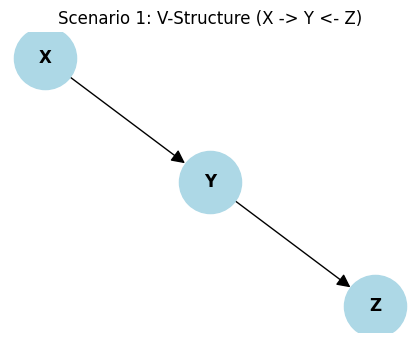

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'A': 'N', 'B': 'N', 'C': 'N'}
Working for n conditional variables: 3:  60%|██████    | 3/5 [00:00<00:00, 387.94it/s]

--- Scenario 2: Chain (A -> B -> C) ---
Edges found: [('B', 'C'), ('B', 'A'), ('C', 'B'), ('A', 'B')]


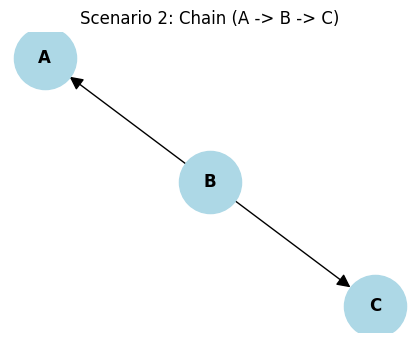

In [ ]:
np.random.seed(42)

def visualize_graph(pdag_edges, title):
    """
    Helper to visualize the resulting graph.
    Note: PC returns a CPDAG (Completed Partially Directed Acyclic Graph),
    so some edges may be undirected.
    """
    G = nx.Graph()
    G.add_edges_from(pdag_edges)
    
    # Create a directed graph for visualization if direction exists
    # In pgmpy output, undirected edges are usually represented as (A, B) and (B, A) 
    # or strictly by how the library outputs them. 
    # For simplicity here, we interpret the raw output.
    
    print(f"--- {title} ---")
    print("Edges found:", pdag_edges)
    
    # Simple drawing
    plt.figure(figsize=(4, 3))
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=2000, font_weight='bold',
            arrows=True, arrowstyle='-|>', arrowsize=20)
    plt.title(title)
    plt.show()

# --- SCENARIO 1: SUCCESS (The V-Structure) ---
# Structure: X -> Y <- Z
# PC *can* identify this direction because X and Z are independent normally,
# but become dependent if you condition on Y. This is a unique statistical signature.

data_v = pd.DataFrame(data=np.random.normal(size=(2000, 3)), columns=['X', 'Y', 'Z'])
# Force the causal relationship
data_v['X'] = np.random.normal(size=2000)
data_v['Z'] = np.random.normal(size=2000)
data_v['Y'] = data_v['X'] + data_v['Z'] + np.random.normal(size=2000) * 0.1

# Run PC
est_v = PC(data_v)
# We typically use 'orig_obs' (original observational) and a significance level (e.g., 0.05)
model_v = est_v.estimate(variant='stable', return_type='cpdag', significance_level=0.01, ci_test='pearsonr')

visualize_graph(model_v.edges(), "Scenario 1: V-Structure (X -> Y <- Z)")


# --- SCENARIO 2: AMBIGUITY (The Chain) ---
# Structure: A -> B -> C
# PC will find the connections, but it CANNOT determine the direction.
# Mathematically, A->B->C looks exactly the same as A<-B<-C or A<-B->C (The Fork).
# They belong to the same "Markov Equivalence Class".

data_chain = pd.DataFrame(data=np.random.normal(size=(2000, 3)), columns=['A', 'B', 'C'])
data_chain['A'] = np.random.normal(size=2000)
data_chain['B'] = data_chain['A'] + np.random.normal(size=2000) * 0.1
data_chain['C'] = data_chain['B'] + np.random.normal(size=2000) * 0.1

# Run PC
est_chain = PC(data_chain)
model_chain = est_chain.estimate(variant='stable', return_type='cpdag', significance_level=0.01, ci_test='pearsonr')

# You will likely see undirected edges here because PC knows they are connected
# but doesn't have enough info to point the arrow.
visualize_graph(model_chain.edges(), "Scenario 2: Chain (A -> B -> C)")

Why did it fail?

```
Edges found: [('B', 'C'), ('B', 'A'), ('C', 'B'), ('A', 'B')]
```

- The PC algorithm usually finds the edges (the skeleton), but cannot orient them.
- Why? $A$ and $C$ are independent given $B$.
- Unfortunately, this is true for three different structures:
    - $A \to B \to C$ (Chain)
    - $A \leftarrow B \leftarrow C$ (Reverse Chain)
    - $A \leftarrow B \to C$ (Fork)

## Approach 2 — Functional Asymmetry (e.g., LiNGAM)

- The Idea: If the data is not normally distributed, we can exploit the "shape" of the noise to find direction.
- Assumption: Linear Non-Gaussian Acyclic Model (LiNGAM): Data is generated by $Y = bX + \epsilon_y$, where the noise $\epsilon_y$ is non-Gaussian.

- The Test: 
    - Regress $Y$ on $X$. Get residuals $R_y$. 
    - Regress $X$ on $Y$. Get residuals $R_x$.
    - Check independence:If $X \to Y$, then $X$ will be independent of $R_y$.But $Y$ will not be independent of $R_x$.
    
Intuition: You can add noise to a cause to get an effect. You cannot subtract noise from an effect to recover the cause cleanly (unless everything is Gaussian).

## How it works

- Step A: Assume $X \rightarrow Y$
    - We run a regression: $Y = aX + \text{error}$.
    - We calculate the residual (noise): $\text{error} = Y - aX$.
    - The Test: Is the error statistically independent of X?
    - If $X \rightarrow Y$ is the true model, the noise is just random external stuff added to $Y$. It should have zero relationship to $X$.
Step B: Assume $Y \rightarrow X$ (The Backward Guess)
    - We run the reverse regression: $X = bY + \text{error}'$.
    - We calculate the new residual.
    - The Test: Is the error' statistically independent of Y? 
    
- If the data is Gaussian, both Step A and Step B will work perfectly. You can't distinguish them.
- If the data is Non-Gaussian, a mathematical phenomenon happens: 
    - In the True Direction ($X \rightarrow Y$), the residuals are independent.
    - In the False Direction ($Y \rightarrow X$), the residuals are dependent (they are correlated in a complex, non-linear way).


--- Running Experiment: NON_GAUSSIAN Noise ---
Estimated Adjacency Matrix:
[[0.         0.        ]
 [0.82931491 0.        ]]
RESULT: SUCCESS. The model detected X -> Y (coeff: 0.83)

--- Running Experiment: GAUSSIAN Noise ---
Estimated Adjacency Matrix:
[[0.         0.46386103]
 [0.         0.        ]]
RESULT: FAILURE. The model incorrectly thought Y -> X


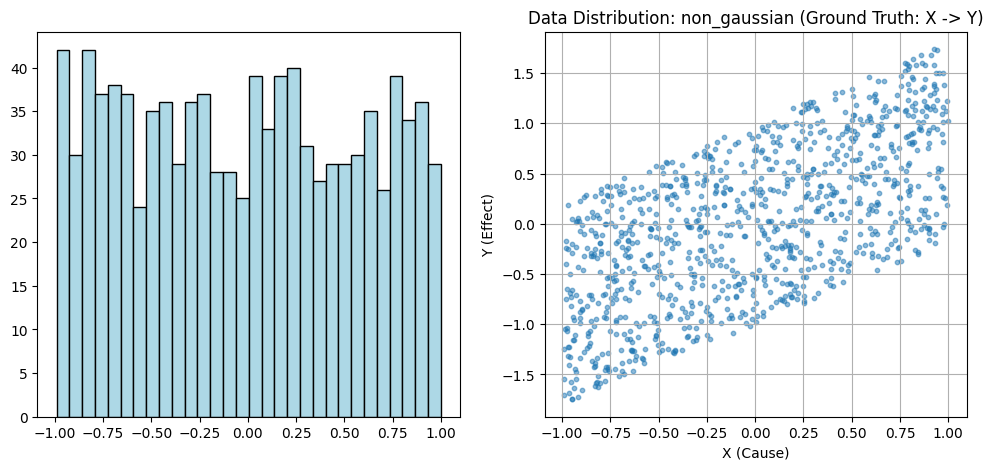

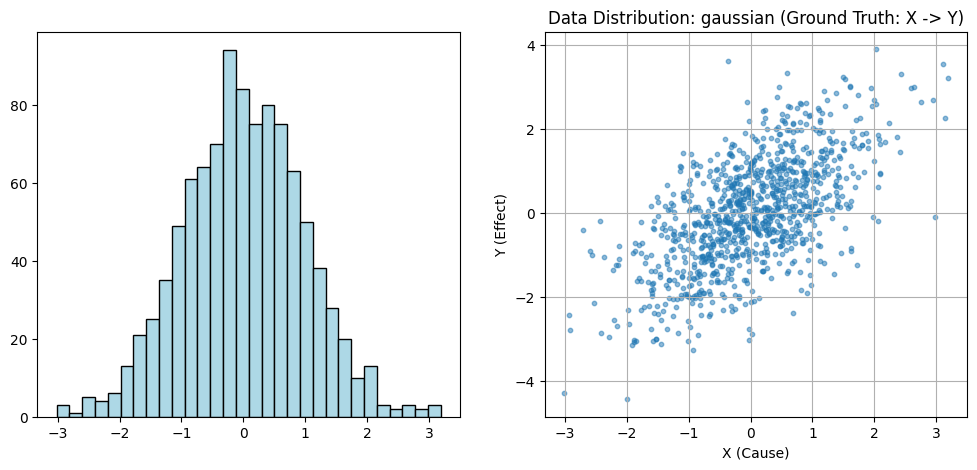

In [14]:
# Set seed for reproducibility
np.random.seed(42)

def run_causal_discovery(noise_type='non_gaussian'):
    """
    Generates data where X -> Y and attempts to recover that direction.
    """
    print(f"\n--- Running Experiment: {noise_type.upper()} Noise ---")
    
    n_samples = 1000
    
    # 1. GENERATE DATA: X -> Y
    # We create a ground truth where X causes Y.
    
    if noise_type == 'non_gaussian':
        # Uniform noise (The "Magic" Scenario)
        # This creates distinct shapes in the data distribution
        x = np.random.uniform(low=-1.0, high=1.0, size=n_samples)
        noise = np.random.uniform(low=-1.0, high=1.0, size=n_samples)
        
    else:
        # Gaussian noise (The "Failure" Scenario)
        # This creates a symmetric 'blob'
        x = np.random.normal(loc=0.0, scale=1.0, size=n_samples)
        noise = np.random.normal(loc=0.0, scale=1.0, size=n_samples)

    # The Causal Mechanism: Y is a function of X plus noise
    y = 0.8 * x + noise
    
    # Create DataFrame
    df = pd.DataFrame({'X': x, 'Y': y})
    
    # 2. RUN CAUSAL DISCOVERY (LiNGAM)
    model = lingam.DirectLiNGAM()
    model.fit(df)
    
    # 3. INTERPRET RESULTS
    # The adjacency matrix tells us the estimated causal strength.
    # Row is "To", Column is "From". 
    # adj[1, 0] means X -> Y
    # adj[0, 1] means Y -> X
    adj = model.adjacency_matrix_
    
    print("Estimated Adjacency Matrix:")
    print(adj)
    
    # Check if it correctly identified X -> Y (Index 0 -> Index 1)
    x_causes_y = abs(adj[1, 0])  # Strength of X -> Y
    y_causes_x = abs(adj[0, 1])  # Strength of Y -> X
    
    if x_causes_y > y_causes_x and x_causes_y > 0.1:
        print(f"RESULT: SUCCESS. The model detected X -> Y (coeff: {x_causes_y:.2f})")
    elif y_causes_x > x_causes_y:
        print(f"RESULT: FAILURE. The model incorrectly thought Y -> X")
    else:
        print("RESULT: AMBIGUOUS. Could not determine direction.")

    # 4. VISUALIZATION (To see WHY it worked/failed)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].hist(df['X'], bins=30, color='lightblue', edgecolor='black')
    ax[1].scatter(df['X'], df['Y'], alpha=0.5, s=10)
    ax[1].set_title(f"Data Distribution: {noise_type} (Ground Truth: X -> Y)")
    ax[1].set_xlabel("X (Cause)")
    ax[1].set_ylabel("Y (Effect)")
    ax[1].grid(True)

# --- EXECUTE BOTH CASES ---

# Case 1: The Success (Non-Gaussian / Uniform)
# Look at the plot produced: it will look like a parallelogram or distinct shape.
# This asymmetry allows the math to see that X is independent, but Y is dependent.
run_causal_discovery(noise_type='non_gaussian')

# Case 2: The Failure (Gaussian)
# Look at the plot produced: it will look like a round/oval blob.
# It is symmetric. Mathematically, X->Y and Y->X are indistinguishable here.
run_causal_discovery(noise_type='gaussian')

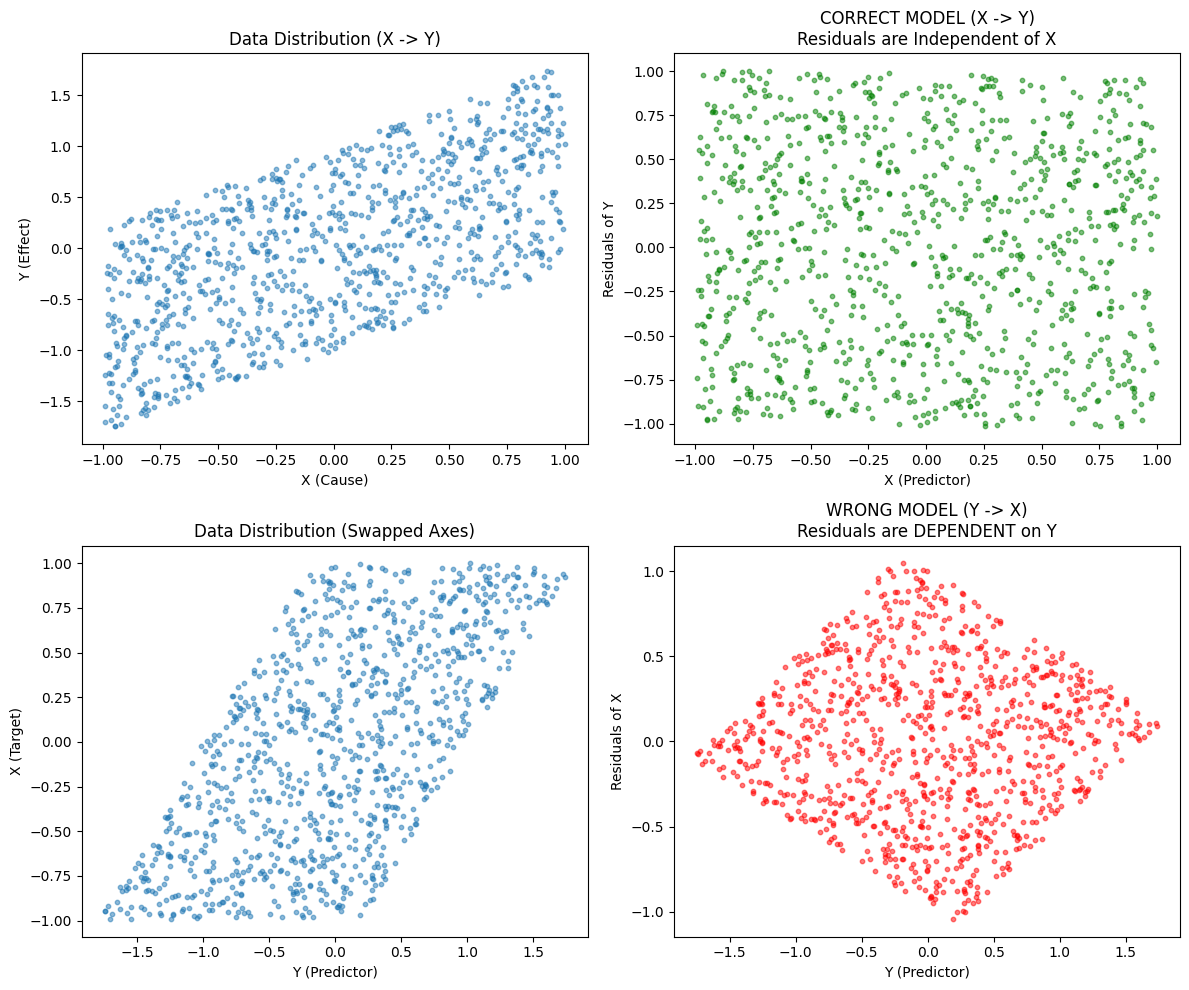

In [23]:
# Set seed for reproducibility
np.random.seed(42)

def visualize_lingam_residuals():
    n_samples = 1000
    
    # 1. GENERATE DATA (True Model: X -> Y)
    # We use Uniform (Non-Gaussian) noise. This is critical.
    x = np.random.uniform(-1.0, 1.0, size=n_samples)
    noise = np.random.uniform(-1.0, 1.0, size=n_samples)
    
    # Y depends on X
    y = 0.8 * x + noise

    # Setup the plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # --- MODEL 1: FORWARD (Correct Direction X -> Y) ---
    # We try to predict Y using X
    reg_xy = LinearRegression()
    reg_xy.fit(x.reshape(-1, 1), y)
    y_pred = reg_xy.predict(x.reshape(-1, 1))
    
    # Calculate Residuals (What the model couldn't explain)
    res_xy = y - y_pred

    # Plot 1: The Data
    axes[0, 0].scatter(x, y, alpha=0.5, s=10)
    axes[0, 0].set_title("Data Distribution (X -> Y)")
    axes[0, 0].set_xlabel("X (Cause)")
    axes[0, 0].set_ylabel("Y (Effect)")
    
    # Plot 2: Residuals vs Predictor
    # If correct, this should look like a random square/blob.
    axes[0, 1].scatter(x, res_xy, alpha=0.5, s=10, c='green')
    axes[0, 1].set_title("CORRECT MODEL (X -> Y)\nResiduals are Independent of X")
    axes[0, 1].set_xlabel("X (Predictor)")
    axes[0, 1].set_ylabel("Residuals of Y")

    # --- MODEL 2: BACKWARD (Wrong Direction Y -> X) ---
    # We try to predict X using Y
    reg_yx = LinearRegression()
    reg_yx.fit(y.reshape(-1, 1), x)
    x_pred = reg_yx.predict(y.reshape(-1, 1))
    
    # Calculate Residuals
    res_yx = x - x_pred

    # Plot 3: The Data (Swapped Axes)
    axes[1, 0].scatter(y, x, alpha=0.5, s=10)
    axes[1, 0].set_title("Data Distribution (Swapped Axes)")
    axes[1, 0].set_xlabel("Y (Predictor)")
    axes[1, 0].set_ylabel("X (Target)")

    # Plot 4: Residuals vs Predictor
    # If wrong, this will look structured (e.g., tilted, bowtie shape).
    axes[1, 1].scatter(y, res_yx, alpha=0.5, s=10, c='red')
    axes[1, 1].set_title("WRONG MODEL (Y -> X)\nResiduals are DEPENDENT on Y")
    axes[1, 1].set_xlabel("Y (Predictor)")
    axes[1, 1].set_ylabel("Residuals of X")

    plt.tight_layout()
    plt.show()

visualize_lingam_residuals()

## Caveats

-  This might go against everything you've heard about econometrics about causal mechanisms *not* being discovered or found using data. 
-  These models work because of very strong assumptions:

- Causal Sufficiency Assumption: You must assume there are no hidden common causes for the variables in your dataset. If there are unmeasured confounders, these algorithms will draw the wrong arrows.
- Faithfulness Assumption: The statistical independences in the data exactly reflect the causal structure (no "perfect deviations" canceling each other out).
- Data Hungry: Conditional independence tests require a lot of data to be reliable.

Conclusion: Causal Discovery tools are best used for Hypothesis Generation, not final proof. They suggest a DAG, which you should then validate with domain experts.

## Using Machine Learnings for Solving the TWFE Problem

- If you remember, an issue with the TWFE DiD estimator is that it can be biased in the presence of treatment effect heterogeneity and staggered adoption of treatment.
- A solution that has come up recently is to matrix completion
- This method treats the panel data as a matrix with missing entries (the counterfactual outcomes) 
- You can think the fundamental problem of causal inference as a missing data problem
    - Since you don't see the counterfactual for treated units as untreated and untreated units as treated
    - You can think of this as a method to try to fill in those missing entries
    - What's a really cool way of filling in missing entries? Predicting them!